# A first projection in OGGM

The OGGM workflow is best explained with an example. In the following, we will show you the OGGM fundamentals ([Doc page: model structure and fundamentals](https://docs.oggm.org/en/stable/structure.html)) and bring you to realize your first OGGM glacier change projection!

## First time set-up 

**If you are using classroom or hub**: nothing to do here, you are all setup! All data is on te online server already.

**If you are using your own computer**: before you start, make sure that you have set-up the [input data configuration file](https://docs.oggm.org/en/stable/input-data.html) at your wish.

### cfg.initialize() and cfg.PARAMS 

An OGGM simulation script will always start with the following commands:

In [1]:
from oggm import cfg, utils
cfg.initialize(logging_level='WARNING')

2023-03-11 23:04:30: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-03-11 23:04:30: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-03-11 23:04:30: oggm.cfg: Multiprocessing: using all available processors (N=8)


A call to [cfg.initialize()](https://docs.oggm.org/en/stable/generated/oggm.cfg.initialize.html) will read the default parameter file (or any user-provided file) and make them available to all other OGGM tools via the `cfg.PARAMS` dictionary. Here are some examples of these parameters:

In [2]:
cfg.PARAMS['melt_f'], cfg.PARAMS['ice_density'], cfg.PARAMS['continue_on_error']

(5.0, 900.0, False)

We set an additional parameter to True for this run:

In [3]:
# Add additional outputs for the maps below
cfg.PARAMS['store_fl_diagnostics'] = True

2023-03-11 23:04:30: oggm.cfg: PARAMS['store_fl_diagnostics'] changed from `False` to `True`.


*More details: see [here](https://github.com/OGGM/oggm/blob/stable/oggm/params.cfg) for the default parameter file and a description of their role and default value.* **Activity: what does `store_fl_diagnostics` do?**

## Workflow

In this section, we will explain the fundamental concepts of the OGGM workflow:
- Working directories
- Glacier directories
- Tasks

In [4]:
from oggm import workflow

### Working directory 

Each OGGM run needs a **single folder** where to store the results of the computations for all glaciers. This is called a "working directory" and needs to be specified before each run. Here we create a temporary folder for you:

In [5]:
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-GettingStarted', reset=True)
cfg.PATHS['working_dir']

'/tmp/OGGM/OGGM-GettingStarted'

We use a temporary directory for this example, but in practice you will set this working directory yourself (for example: `/home/erika/OGGM_output`. The size of this directory will depend on how many glaciers you'll simulate!

<div class="alert alert-info">
    <b>
        In the OGGM design, this working directory is meant to be persistent, at least as long as you need the data for. For example, you can stop your processing workflow after any task, and restart from an existing working directory at a later stage, simply by using the same working directory.
    </b>
</div>

You can create a persistent OGGM working directory at a specific path via `path = utils.mkdir(path)`. **Beware!** If you use `reset=True` in `utils.mkdir`, ALL DATA in this folder will be deleted!

### Define the glaciers for the run 

In [6]:
rgi_ids = ['RGI60-11.00897']

You can provide any number of glacier identifiers to OGGM. For this special Workshop, we chose:

- `RGI60-11.00897`: [Hintereisferner](http://acinn.uibk.ac.at/research/ice-and-climate/projects/hintereisferner) in the Austrian Alps.

Here is a list of other glaciers you might use later:
- `RGI60-14.06794`: [Baltoro](https://en.wikipedia.org/wiki/Baltoro_Glacier) in Pakistan
- `RGI60-14.04638`: [Chogo](https://en.wikipedia.org/wiki/Chogo_Lungma_Glacier) in Pakistan
- `RGI60-11.01328`: [Unteraar Glacier](https://en.wikipedia.org/wiki/Unteraargletscher) in the Swiss Alps
- `RGI60-18.02342`: Tasman Glacier in New Zealand
- `RGI60-11.00787`: [Kesselwandferner](https://de.wikipedia.org/wiki/Kesselwandferner) in the Austrian Alps
- ... or any other glacier identifier! You can find other glacier identifiers by exploring the [GLIMS viewer](https://www.glims.org/maps/glims).

*More detail: when we do basin scale or global runs, we use the [Randolph Glacier Inventory](https://www.glims.org/RGI/) dataset instead, and start a run from it. This case is covered in the [working with the RGI](https://oggm.org/tutorials/stable/notebooks/beginner/working_with_rgi.html) tutorial.*

### Glacier directories 

The OGGM workflow is organized as a list of **tasks** that have to be applied to a list of glaciers. The vast majority of tasks are called **entity tasks**: they are standalone operations to be realized on one single glacier entity. These tasks are executed sequentially (one after another): they often need input generated by the previous task(s): for example, the mass balance calibration needs the glacier flowlines, which can only be computed after the topography data has been processed, and so on.

To handle this situation, OGGM uses a workflow based on data persistence on disk: instead of passing data as python variables from one task to another, each task will read the data from disk and then write the computation results back to the disk, making these new data available for the next task in the queue.

These glacier specific data are located in [glacier directories](https://docs.oggm.org/en/stable/glacierdir.html#glacier-directories). In the model, these directories are initialized with the following command:

In [7]:
# Where to fetch the pre-processed directories
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5'
gdirs = workflow.init_glacier_directories(rgi_ids, prepro_base_url=base_url, from_prepro_level=4, prepro_border=80)

2023-03-11 23:04:51: oggm.workflow: init_glacier_directories from prepro level 4 on 1 glaciers.
2023-03-11 23:04:51: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


- the keyword `from_prepro_level` indicates that we will start from [pre-processed directories](https://docs.oggm.org/en/stable/shop.html#pre-processed-directories), i.e. data that are already prepared by the OGGM team. In many cases you will want to start from pre-processed directories. Here we start from level 4 and add some data to the processing in order to demonstrate the OGGM workflow.
- the `prepro_border` keyword indicates the number of grid points which we'd like to add to each side of the glacier for the local map. For future runs where the glacier is likely to shrink, 80 is enough. For past runs however a larger value is necessary: the larger the glacier will grow, the larger the border parameter should be. The available pre-processed border values are: **10, 80, 160, 240**. 

*More detail: these are the fixed map sizes we prepared for you - any other map size will require a full processing (see the [further DEM sources example](https://oggm.org/tutorials/stable/notebooks/advanced/dem_sources.html) for a tutorial).*

The [init_glacier_directories](https://docs.oggm.org/en/stable/generated/oggm.workflow.init_glacier_directories.html#oggm.workflow.init_glacier_directories) task will allways be the very first task to call for all your OGGM experiments. Let's see what it gives us back:

In [8]:
type(gdirs), type(gdirs[0])

(list, oggm.utils._workflow.GlacierDirectory)

`gdirs` is a list of [GlacierDirectory](https://docs.oggm.org/en/stable/generated/oggm.GlacierDirectory.html#oggm.GlacierDirectory) objects (one for each glacier). **Glacier directories are used by OGGM as "file and attribute manager"** for single glaciers. For example, the model now knows where to find the topography data file for this glacier:

In [9]:
gdir = gdirs[0]  # take the glacier
print('Path to the DEM:', gdir.get_filepath('dem'))

Path to the DEM: /tmp/OGGM/OGGM-GettingStarted/per_glacier/RGI60-11/RGI60-11.00/RGI60-11.00897/dem.tif


And we can also access some attributes of this glacier:

In [10]:
gdir

<oggm.GlacierDirectory>
  RGI id: RGI60-11.00897
  Region: 11: Central Europe
  Subregion: 11-01: Alps                            
  Name: Hintereisferner
  Glacier type: Glacier
  Terminus type: Land-terminating
  Status: Glacier or ice cap
  Area: 8.036 km2
  Lon, Lat: (10.7584, 46.8003)
  Grid (nx, ny): (279, 234)
  Grid (dx, dy): (50.0, -50.0)

In [11]:
gdir.rgi_date  # date at which the outlines are valid

2003

The advantage of this Glacier Directory data model is that it simplifies greatly the data transfer between tasks. **The single mandatory argument of most OGGM commands will allways be a glacier directory**. With the glacier directory, each OGGM task will find the input it needs: for example, both the glacier's topography and outlines are needed for the next plotting function, and both are available via the `gdir` argument:

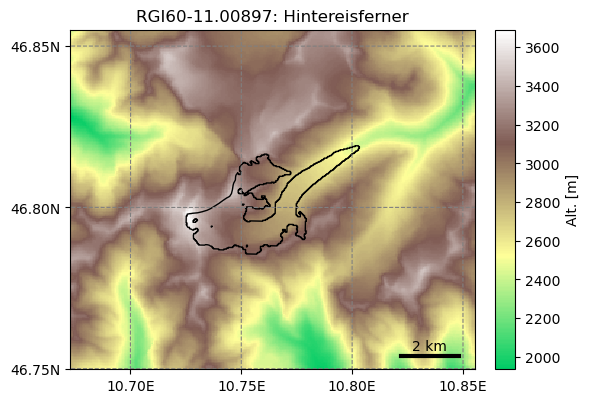

In [12]:
from oggm import graphics
graphics.plot_domain(gdir, figsize=(6, 5))

Another advantage of glacier directories is their persistence on disk: once created, **they can be recovered from the same location** by using `init_glacier_directories` again, but without keyword arguments:

In [13]:
# Fetch the LOCAL pre-processed directories - note that no arguments are used!
gdirs = workflow.init_glacier_directories(rgi_ids)

2023-03-11 23:04:52: oggm.workflow: Execute entity tasks [GlacierDirectory] on 1 glaciers


*More detail: see the [store_and_compress_glacierdirs](https://oggm.org/tutorials/stable/notebooks/beginner/store_and_compress_glacierdirs.html) tutorial for more information on glacier directories and how to use them for operational workflows.*

### Accessing data in the preprocessed directories

Glacier directories are the central object for model users and developpers to access data for this glacier. Let's say for example that you would like to retrieve the climate data that we have prepared for you. You can ask the glacier directory to tell you where this data is:

In [14]:
gdir.get_filepath('climate_historical')

'/tmp/OGGM/OGGM-GettingStarted/per_glacier/RGI60-11/RGI60-11.00/RGI60-11.00897/climate_historical.nc'

The ending `.nc` tells us that the climate data is saved as a NetCDF file. As a result of the processing workflow the glacier directories can store many more files. If you are interested, you can have a look at the list:

In [15]:
import os
print(os.listdir(gdir.dir))

['mb_calib.json', 'model_diagnostics_historical.nc', 'diagnostics.json', 'downstream_line.pkl', 'elevation_band_flowline.csv', 'intersects.tar.gz', 'model_flowlines.pkl', 'inversion_input.pkl', 'climate_historical.nc', 'log.txt', 'model_geometry_historical.nc', 'glacier_grid.json', 'inversion_output.pkl', 'dem_source.txt', 'dem.tif', 'inversion_flowlines.pkl', 'gridded_data.nc', 'outlines.tar.gz']


For a short explanation of what these files are, see the [glacier directory documentation](https://docs.oggm.org/en/stable/api.html#cfg-basenames). In practice, however, you will only access a couple of these files yourself.

But, for now, let's focus on the NetCDF file `climate_historical.nc`. For these files the python libary [xarray](https://xarray.pydata.org/en/stable/) can be used to read and process the data further.

### Working with Xarray

First import xarray and open the NetCDF file:

In [16]:
# import xarray and matplotlib
import xarray as xr
import matplotlib.pyplot as plt

# and open the NetCDF file and load it in memory
with xr.open_dataset(gdir.get_filepath('climate_historical')) as ds:
    ds = ds.load()

And have a look at it's structure:

In [17]:
ds

<xarray.Dataset>
Dimensions:   (time: 1428)
Coordinates:
  * time      (time) datetime64[ns] 1901-01-01 1901-02-01 ... 2019-12-01
Data variables:
    prcp      (time) float32 17.59 29.17 120.8 93.4 ... 90.42 67.95 170.7 52.07
    temp      (time) float32 -9.867 -12.65 -7.506 -3.411 ... 5.1 3.3 -3.0 -4.1
    temp_std  (time) float32 4.757 5.564 3.448 3.511 ... 2.986 2.344 3.095 2.942
Attributes:
    ref_hgt:         2252.0
    ref_pix_lon:     10.75
    ref_pix_lat:     46.75
    ref_pix_dis:     5629.566753389074
    climate_source:  GSWP3_W5E5
    yr_0:            1901
    yr_1:            2019
    author:          OGGM
    author_info:     Open Global Glacier Model

You see the resulting `xarray.Dataset` consists of **Coordinates** (`time`), **Data variables** (`prcp`, `temp` and `temp_std`) and **Attributes** (for example `ref_hgt`), which give you more background information about the Dataset:

In [18]:
ds.climate_source, ds.ref_hgt

('GSWP3_W5E5', 2252.0)

- `climate_source` is the dataset we used for the historical period. **Activity: from the attributes in the file, can you determine the period covered by the dataset? If you are interested, use a search engine to check what W5E5 is, and then GSWP3**
- `ref_hgt` is the elevation of the W5E5 gridpoint. 

In an xarray dataset, coordinates can be used to select parts of the data variables based on conditions. For example, we can select data at specific times (e.g. the same month of two different years):

In [19]:
ds.sel(time=['2000-09-01', '2010-09-01'])

<xarray.Dataset>
Dimensions:   (time: 2)
Coordinates:
  * time      (time) datetime64[ns] 2000-09-01 2010-09-01
Data variables:
    prcp      (time) float32 83.88 85.02
    temp      (time) float32 4.7 2.9
    temp_std  (time) float32 2.547 2.891
Attributes:
    ref_hgt:         2252.0
    ref_pix_lon:     10.75
    ref_pix_lat:     46.75
    ref_pix_dis:     5629.566753389074
    climate_source:  GSWP3_W5E5
    yr_0:            1901
    yr_1:            2019
    author:          OGGM
    author_info:     Open Global Glacier Model

Or we can select data for a time range:

In [20]:
ds.sel(time=slice('2010', '2019'))

<xarray.Dataset>
Dimensions:   (time: 120)
Coordinates:
  * time      (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2019-12-01
Data variables:
    prcp      (time) float32 18.43 30.06 39.15 26.82 ... 90.42 67.95 170.7 52.07
    temp      (time) float32 -9.8 -8.4 -6.2 -2.0 0.5001 ... 5.1 3.3 -3.0 -4.1
    temp_std  (time) float32 3.382 4.246 5.955 4.117 ... 2.986 2.344 3.095 2.942
Attributes:
    ref_hgt:         2252.0
    ref_pix_lon:     10.75
    ref_pix_lat:     46.75
    ref_pix_dis:     5629.566753389074
    climate_source:  GSWP3_W5E5
    yr_0:            1901
    yr_1:            2019
    author:          OGGM
    author_info:     Open Global Glacier Model

**Activity: can you see what changed between the two selections? Where?**

This is quite convenient, but xarray can be used for much more than this. for example, it is very easy to have a look at the complete timeseries of a variable by plotting it:

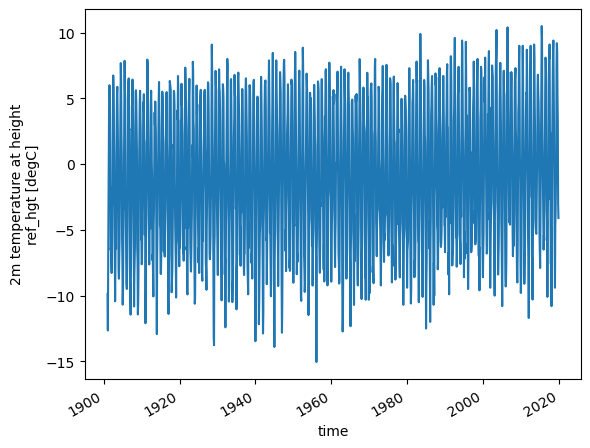

In [21]:
ds.temp.plot();  # take "temp" and plot it

**Activity: select the 2000-2019 period and plot the temperature. Identify the three warmest summers and the mildest winter.**

In [22]:
# your answer here

Xarray is also very useful to compute statistics at various aggregation levels. Let's start with the simple mean:

In [23]:
# e.g. calculate the mean temperature over the whole period
ds.temp.mean()

<xarray.DataArray 'temp' ()>
array(-1.0189681, dtype=float32)

More powerful, computing annual averages is also a one liner:

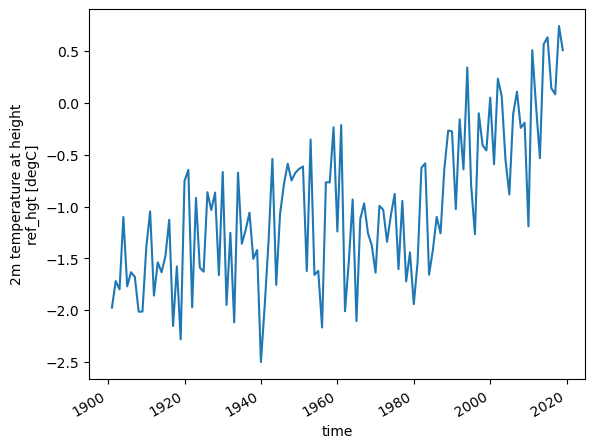

In [24]:
# or calculate the annual mean temperature and plot it
temp_annual = ds.temp.resample(time='AS').mean()
temp_annual.plot();

Resampling is the operation of changing the sampling of the data, i.e. the frequency at which it is sampled. And with  `'AS'` we set the frequency to Annual Start (you can find all aliases in the [pandas documentation](http://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases), another useful python package). Note that you can use resampling not only for `.mean()`, but also for other operations like `.std()` or `.max()`.

Or we can compute the 31 year rolling mean, using `.rolling()`:

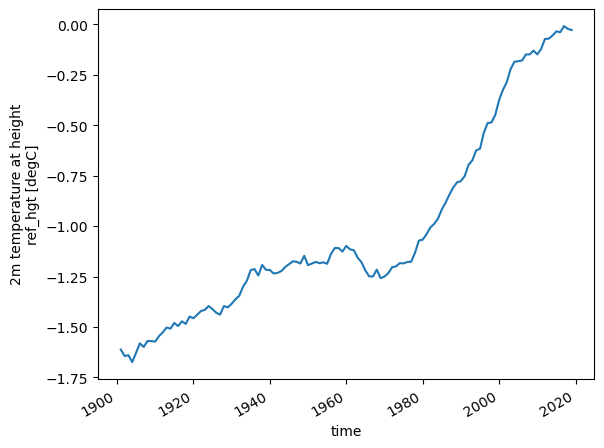

In [25]:
temp_31yr = temp_annual.rolling(time=31, center=True, min_periods=15).mean()
temp_31yr.plot();

**Activity: we will now try to bring everything together and get our hands dirty. The task is to create a plot of the annual mean temperature overlayed with the 31 year averaged annual mean temperature (hint: calling `.plot()` two times in a row creates an overlay).**

Both curves should incude labels and the plot should include a legend (hint: this is explained for matplotlib in [01_getting_started_with_notebooks](01_getting_started_with_notebooks.ipynb)). Lets go!

In [26]:
import matplotlib.pyplot as plt

# Plot the data
# first, plot mean annual temperture including a label
# --------- ENTER YOUR CODE HERE ---------

# second, plot 30 year averaged annual mean temperture including a label
# --------- ENTER YOUR CODE HERE ---------

# finally, add a legend to the plot
# --------- ENTER YOUR CODE HERE ---------

The solution can be found [here](02_solution_oggm_intro.ipynb).

Now, lets get back to OGGM.

### OGGM tasks

There are two different types of "[tasks](http://docs.oggm.org/en/stable/api.html#entity-tasks)" in OGGM:

**Entity Tasks**
: Standalone operations to be realized on one single glacier entity, independently from the others. The majority of OGGM tasks are entity tasks. They are parallelisable: the same task can run on several glaciers in parallel.

**Global Tasks**
: Tasks which require to work on several glacier entities at the same time. Model parameter calibration or the compilation of several glaciers' output are examples of global tasks. 
  
OGGM implements a simple mechanism to run a specific task on a list of `GlacierDirectory` objects: [workflow.execute_entity_task](https://docs.oggm.org/en/stable/generated/oggm.workflow.execute_entity_task.html#oggm.workflow.execute_entity_task). Let's apply this workflow to process climate projection data for our glacier.

## Download and process GCM data from ISIMIP3b (bias-corrected CMIP6)

A typical use case for OGGM will be to use climate model output (here bias-corrected CMIP6 GCMs from [ISIMIP3b](https://www.isimip.org/gettingstarted/isimip3b-bias-adjustment/)). We use some of the files [we mirrored in Bremen](https://cluster.klima.uni-bremen.de/~oggm/cmip6/isimip3b/flat/monthly/) here, but you can use whichever you want. From ISIMIP3b, we have 5 GCMs and 3 SSPs on the cluster. You can find more information on the [ISIMIP website](https://www.isimip.org/gettingstarted/isimip3b-bias-adjustment). 

Let's download and process the data for one model and one scenario:

In [27]:
from oggm.shop import gcm_climate

# you can choose one of these 5 different GCMs:
# 'gfdl-esm4_r1i1p1f1', 'mpi-esm1-2-hr_r1i1p1f1', 'mri-esm2-0_r1i1p1f1' ("low sensitivity" models, within typical ranges from AR6)
# 'ipsl-cm6a-lr_r1i1p1f1', 'ukesm1-0-ll_r1i1p1f2' ("hotter" models, especially ukesm1-0-ll)
member = 'mri-esm2-0_r1i1p1f1'

# The sscenario. You can choose from 'ssp126', 'ssp370','ssp585'
ssp = 'ssp126'

workflow.execute_entity_task(gcm_climate.process_monthly_isimip_data, gdirs, 
                             ssp=ssp,  # SSP scenario -> you can choose another one later
                             member=member,  # ensemble member -> you can choose another one later
                             output_filesuffix=f'_ISIMIP3b_{member}_{ssp}',  # make the output file recognizable for later
                             );

2023-03-11 23:04:54: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers


The advantage of using ISIMIP3b data is that they have been bias-corrected by the ISIMIP consortium. Since we are using the [W5E5](https://www.isimip.org/gettingstarted/input-data-bias-adjustment/details/78/) dataset as baseline historical data in OGGM v1.6, there is no need for us to bias correct any further. 

*More detail: if you want to bias-correct yourself the projections and want to have a larger variety of GCMs, you can also use the original CMIP5 or CMIP6 GCMs: more information in a further tutorial.*

OK, let's have a look at the data, once again with xarray:

In [28]:
# and open the NetCDF file and load it in memory
with xr.open_dataset(gdir.get_filepath('gcm_data', filesuffix=f'_ISIMIP3b_{member}_{ssp}')) as dsgcm:
    dsgcm = dsgcm.load()

**Activity: plot the annual GCM temperature overlayed to the historical data. Discuss the length of the timeseries and the bias correction.**

In [29]:
# Your answer here

## Run OGGM with ISIMIP3b data

Now we have everything we need to do a run. Once more, we use the entity task mechanism:

In [30]:
from oggm import tasks

rid = f'_ISIMIP3b_{member}_{ssp}'
workflow.execute_entity_task(tasks.run_from_climate_data, gdirs,
                             climate_filename='gcm_data',  # use gcm_data, not climate_historical
                             climate_input_filesuffix=rid,  # use the chosen scenario
                             init_model_filesuffix='_historical',  # this is important! Start from 2020 glacier
                             output_filesuffix=rid,  # recognize the run for later
                             );

2023-03-11 23:04:55: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers


That was quick! Note that we started the simulation in 2020, from a pre-existing historical simulation. We will get back to these (important) details later in the workshop.

Now let's have a look at the data. Guess which tool we are going to use for this? ;-)

In [31]:
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix=rid)) as dsproj:
    dsproj = dsproj.load()

In [32]:
dsproj

<xarray.Dataset>
Dimensions:           (time: 82)
Coordinates:
  * time              (time) float64 2.02e+03 2.021e+03 ... 2.1e+03 2.101e+03
    calendar_year     (time) int64 2020 2021 2022 2023 ... 2098 2099 2100 2101
    calendar_month    (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    hydro_year        (time) int64 2020 2021 2022 2023 ... 2098 2099 2100 2101
    hydro_month       (time) int64 4 4 4 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4 4 4 4
Data variables:
    volume_m3         (time) float64 4.502e+08 4.384e+08 ... 1.006e+07 1.031e+07
    volume_m3_min_h   (time) float64 4.502e+08 4.384e+08 ... 8.605e+06 8.709e+06
    volume_bsl_m3     (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    volume_bwl_m3     (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    area_m2           (time) float64 7.673e+06 7.649e+06 ... 4.85e+05 4.854e+05
    area_m2_min_h     (time) float64 7.673e+06 7.649e+06 ... 2.981e+05 2.984e+05
    length_m          (time) float64 5.3e+03 5.3e+03 5.3e+03 ... 500.0 500.0
    calving_m3        (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    calving_rate_myr  (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    description:          OGGM model output
    oggm_version:         1.5.4.dev30+gcd86bbe.d20220905
    calendar:             365-day no leap
    creation_date:        2023-03-11 18:04:55
    water_level:          0
    glen_a:               6.079411329372713e-24
    fs:                   0
    mb_model_class:       MultipleFlowlineMassBalance
    mb_model_hemisphere:  nh

This dataset has a few more variables than the climate files. For today, `volume_m3`, `area_m2` and `length_m` are the most interesting. Let's plot the volume:

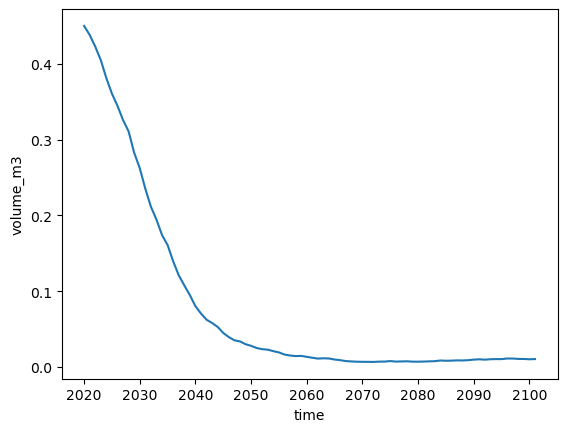

In [33]:
volkm3 = dsproj.volume_m3 * 1e-9  # convert to km3
volkm3.plot();

**Activity: similarly, have a look at the `area_m2` and `length_m` variables.**

## Now run the two other scenarios and plot their volume change 

**Activity: similar to the run above, run the `ssp370` and `ssp585` scenarios. Compare them to the `ssp126` scenario.**

Tip: if you can't go any further, you can have a look at the [solution](02_solution_oggm_intro.ipynb).

## Bonus: plot the glacier geometry 

All these line plots above are a bit dry. Another way to plot glacier change is to have a look at the changing geometry over time. For this, we need additional diagnostics (these are usually not stored per default, because they require more disk space):

In [36]:
with xr.open_dataset(gdir.get_filepath('fl_diagnostics', filesuffix=rid), group=f'fl_0') as dsfl:
    dsfl = dsfl.load()
dsfl

<xarray.Dataset>
Dimensions:             (dis_along_flowline: 105, time: 82)
Coordinates:
  * dis_along_flowline  (dis_along_flowline) float64 0.0 100.0 ... 1.04e+04
  * time                (time) float64 2.02e+03 2.021e+03 ... 2.1e+03 2.101e+03
Data variables:
    bed_h               (dis_along_flowline) float64 3.581e+03 ... 2.149e+03
    volume_m3           (time, dis_along_flowline) float64 2.002e+06 ... 0.0
    volume_bsl_m3       (time, dis_along_flowline) float64 0.0 0.0 ... 0.0 0.0
    volume_bwl_m3       (time, dis_along_flowline) float64 0.0 0.0 ... 0.0 0.0
    area_m2             (time, dis_along_flowline) float64 7.569e+04 ... 0.0
    thickness_m         (time, dis_along_flowline) float64 27.44 28.07 ... 0.0
    ice_velocity_myr    (time, dis_along_flowline) float64 nan nan ... 0.0 0.0
    calving_bucket_m3   (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    calendar:             365-day no leap
    water_level:          0
    dx:                   2.0
    creation_date:        2023-03-11 18:04:55
    fs:                   0
    mb_model_class:       MultipleFlowlineMassBalance
    map_dx:               50.0
    class:                MixedBedFlowline
    glen_a:               6.079411329372713e-24
    oggm_version:         1.5.4.dev30+gcd86bbe.d20220905
    mb_model_hemisphere:  nh
    description:          OGGM model output

These data are structured differently. Note the new dimension: `dis_along_flowline`, which is the distance from top to bottom of the numerical domain. Let's have a look at the glacier bed first:

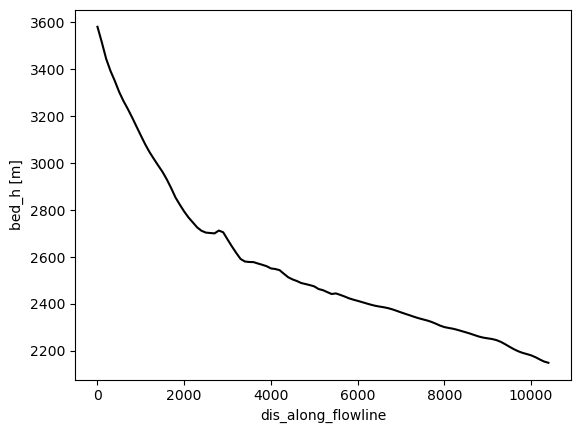

In [38]:
dsfl.bed_h.plot(color='k');

OK, fine. What about ice thickness? 

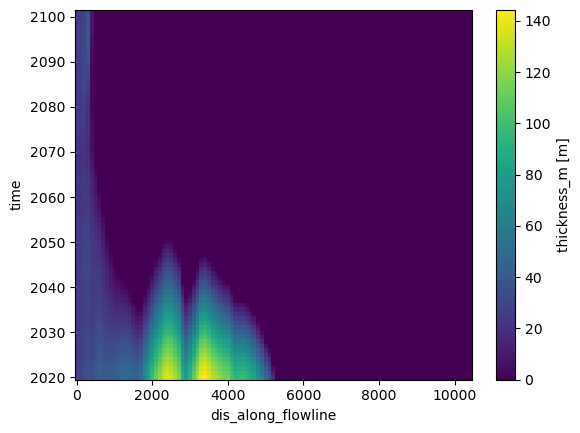

In [39]:
dsfl.thickness_m.plot();

This plot is much harder to interpret. On the x axis, we have the flowline, and on y the time. Maybe it will become clearer if we compute the surface elevation instead, and plot only selected times:

In [40]:
surface_h = dsfl.bed_h + dsfl.thickness_m

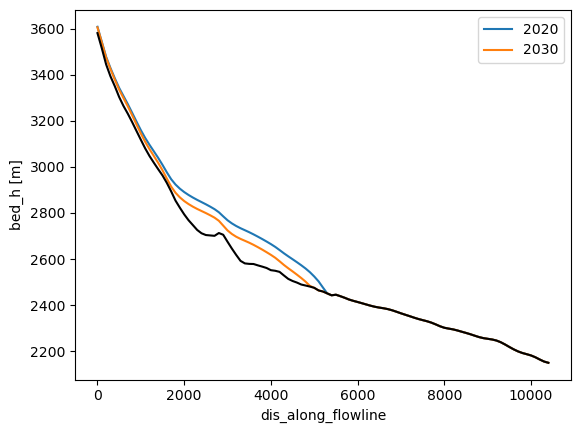

In [44]:
surface_h.sel(time='2020').plot(label='2020');
surface_h.sel(time='2030').plot(label='2030');
dsfl.bed_h.plot(color='k');
plt.legend();

Now that it is clearer what we are looking at (maybe), let's use quite some more xarray magic:

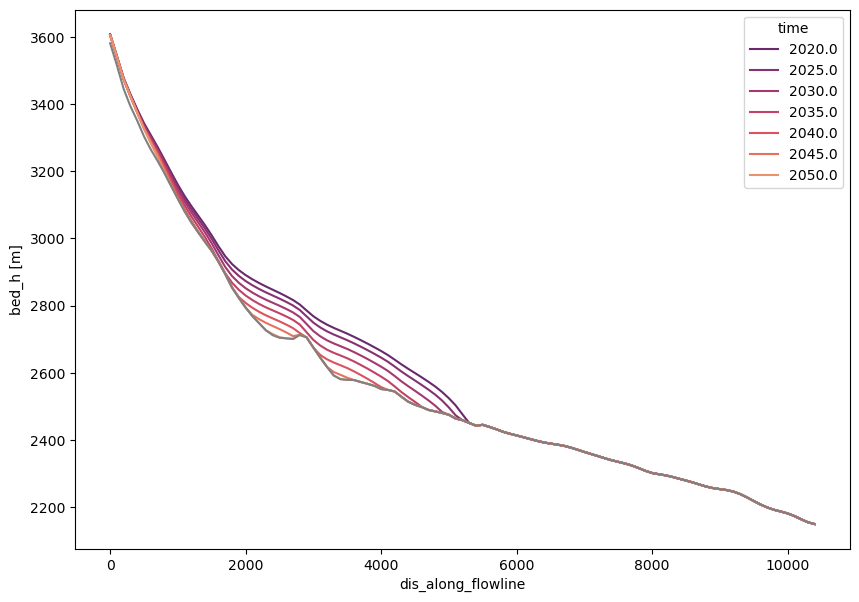

In [78]:
import numpy as np
import seaborn as sns

time_sel = np.linspace(2020, 2050, 7)
colors = sns.color_palette('flare_r', len(time_sel))

with plt.rc_context({'axes.prop_cycle': plt.cycler(color=colors)}):
    f, ax = plt.subplots(figsize=(10, 7))
    surface_h.sel(time=time_sel).plot(ax=ax, hue='time')
    dsfl.bed_h.plot(ax=ax, c='grey')

## Recap 

- OGGM is a "glacier centric" model, i.e. it operates on a list of glaciers
- OGGM relies on saving files to disk during the workflow. Therefore, users must always specify a working directory while running OGGM
- The working directory can be used to restart a run at a later stage
- Put simply, this "restart workflow" is what OGGM uses to deliver data to its users. Pre-processed directories are online folders filled with glacier data that users can download
- Once initialized locally, "glacier directories" allow OGGM to do what it does best: apply processing tasks to a list of glacier entities. These "entity tasks" get the data they need from disk, and write to disk once completed.
- Users (or subsequent OGGM tasks) can use these data for new computations.